# Homework 2
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

Name: Sadjad Bazarnovi <br>
Email: sbazar3@uic.edu <br>
UIN: 679314994 <br>

please add your information here

## 1. CNNs and finetuning

In [1]:
import torch
from torch import mps
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

# previously calculated normalization values
mean = [0.4934569299, 0.483376652, 0.4471793473]
std = [0.2476211786, 0.2445851415, 0.2626110017]

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

unaugmented_transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

Torch Device: mps


We next download the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) from the pytorch website and apply the transforms. The `unaugumented_set` is 50/50 split into a `test_set` and `val_set` using the `random_split` utility.

In [2]:
import torchvision.datasets as datasets
from torch.utils.data import random_split

train_set = datasets.CIFAR10("./Misc_files/data", train=True, transform=train_transform, download=True)

unaugmented_set = datasets.CIFAR10("./Misc_files/data", train=False, transform=unaugmented_transform, download=True)

test_set, val_set = random_split(unaugmented_set, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


The train, test, and validation sets are then passed to a `Dataloader` iterable with a common practice `batch_size` of 64:

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 64, shuffle=False)

With the datasets finalized we can additionally view some sample instances of the data. Plotting instances of the training set can additionally show the results of of the data augmentations (`RandomRotation` is apparent).

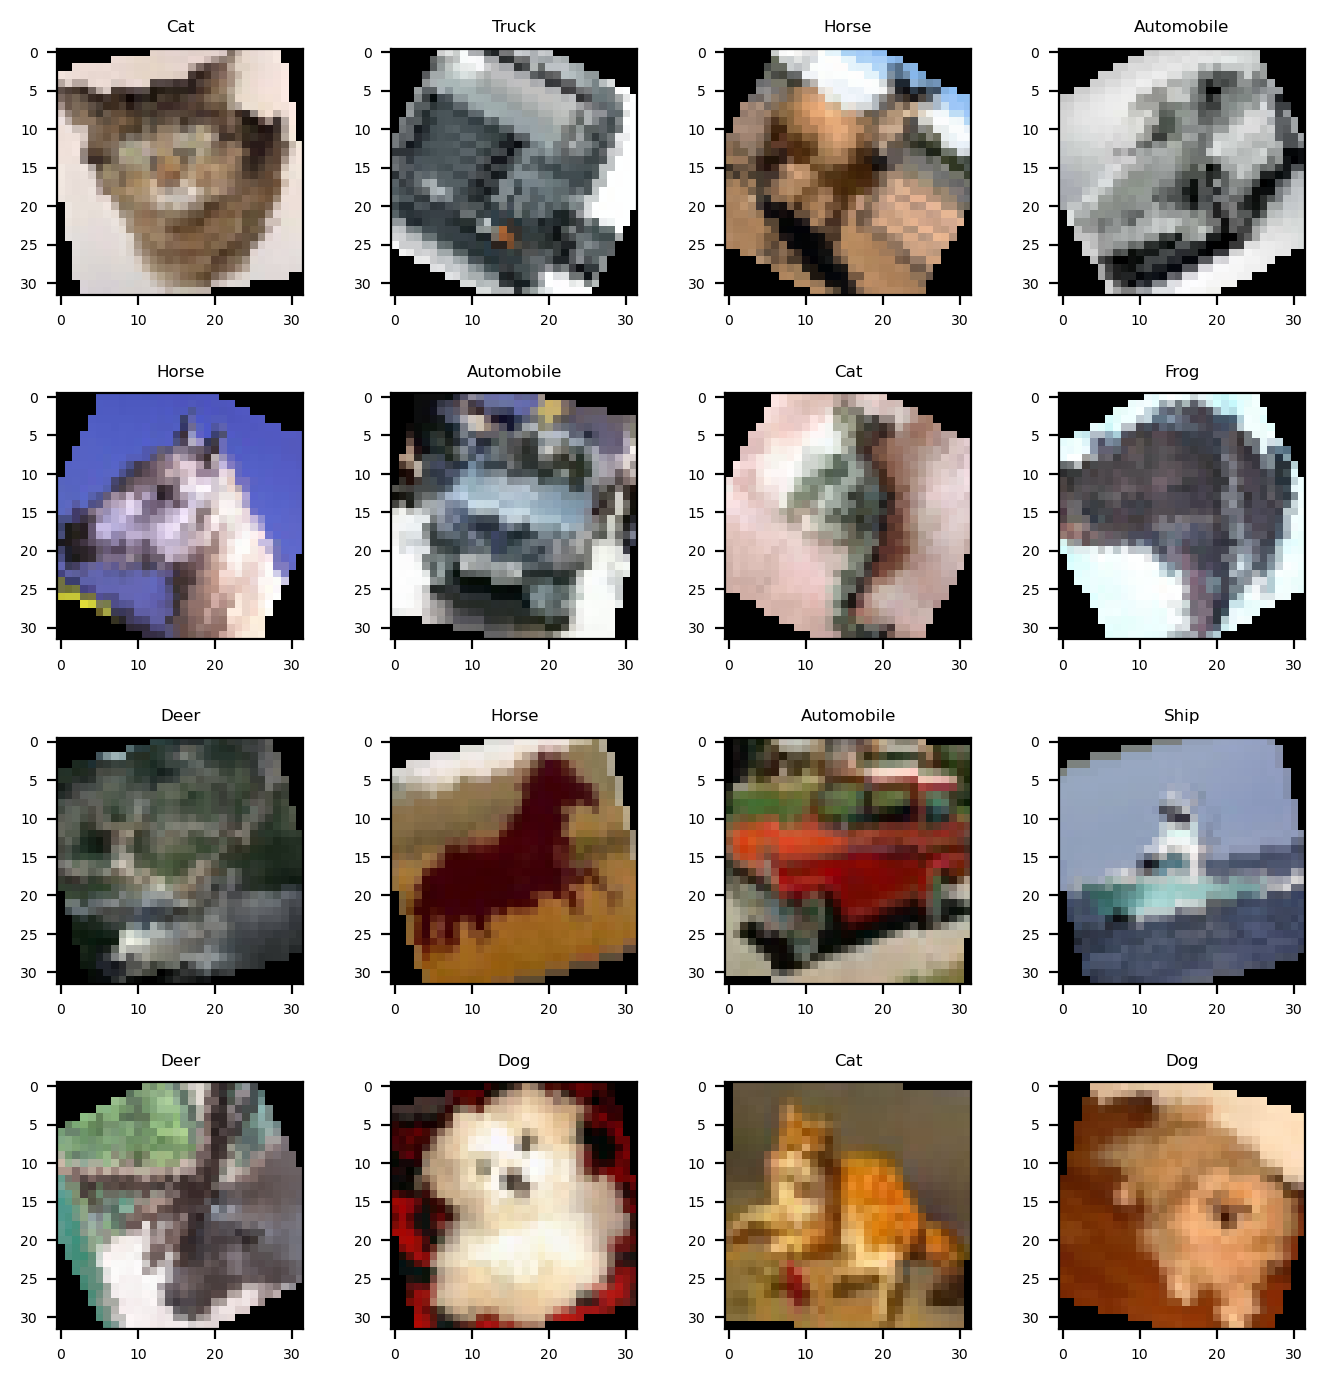

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

CIFAR10_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

images, labels = next(iter(train_loader))

# Define plot size and DPI
fig = plt.figure(figsize=(8, 8), dpi=200)

# Adjust space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(CIFAR10_labels.get(int(labels[i])))
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1.)
    plt.imshow(img)

plt.show()

Using torch's `nn` module, we can create a logisitic regression model comprised of the following layers:
1. A `ReLU` layer that serves as the activation for `ResNet18`'s last linear layer.
2. A `Linear` layer whose output corresponds to the 10 categories in the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

We can additionally specify the loss `criterion` and `optimizer` algorithm for our training loop.
- `CrossEntropyLoss()` loss function was selected to train classification with _C_ classes.
- `Adam` optmizer was selected due to it's performant qualities while training.

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

# create transfer learning model
resnet18_based = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in resnet18_based.parameters():
    param.requires_grad = False

num_ftrs = resnet18_based.fc.in_features
resnet18_based.fc = nn.Linear(num_ftrs, 10)

resnet18_based.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet18_based.fc.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

We can now devise a training loop for our `new_classifier`. Each epoch iteration performs a forward and backward pass per batch in the training data and evaluates on validation data after each epoch. The function returns a dictionary containing the model and relevant training statistics.

In [6]:
from tqdm.notebook import tqdm

# Define a function to compute accuracy
def calculate_accuracy(outputs, labels):
    
    softmax = nn.Softmax(dim = 1)
    
    outputs = softmax(outputs)
    
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_model(model, criterion, optimizer, train_loader: DataLoader, 
                val_loader: DataLoader = None, scheduler = None, num_epochs=25, verbose = 5):

    # model training history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        
        train_loss = 0
        total_accuracy = 0
        
        # Iterate over data.
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass and loss calculation
            with torch.set_grad_enabled(True):
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)        

                # backward pass
                # loss.requires_grad = True
                loss.backward()
                optimizer.step()

            # training loss per batch    
            train_loss += loss.item()
            
            # training statistics
            batch_accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += batch_accuracy
            
        # update scheduler
        if scheduler != None:
            scheduler.step()

        # validation on epoch
        if val_loader != None:

            # training statistics
            val_loss = 0
            val_accuracy = 0

            # set model to evaluation
            model.eval()

            for data in tqdm(val_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass and loss calc
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

                val_batch_accuracy = calculate_accuracy(outputs, labels)
                val_accuracy += val_batch_accuracy

        # Calculate average accuracy for the epoch
        epoch_accuracy = total_accuracy / len(train_loader)
        train_acc_history.append(epoch_accuracy)
        
        epoch_loss = train_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
        
        if val_loader != None:
            
            epoch_val_accuracy = val_accuracy / len(val_loader)
            val_acc_history.append(epoch_val_accuracy)
            
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(float(epoch_val_loss))
            
            print('Validation Loss: {:.4f}\tValidation Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_accuracy))

    history = {
        "model": model.to("cpu"),
        "train loss": train_loss_history,
        "validation loss": val_loss_history,
        "train accuracy": train_acc_history,
        "validation accuracy": val_acc_history
    }    

    return history



In [7]:
trained_classifier = train_model(resnet18_based, criterion, 
                                 optimizer, train_loader, val_loader, num_epochs=20)

Epoch 1/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.8830	Train Accuracy: 0.3319
Validation Loss: 1.7966	Validation Accuracy: 0.3675

Epoch 2/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7825	Train Accuracy: 0.3690
Validation Loss: 1.7302	Validation Accuracy: 0.3884

Epoch 3/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7701	Train Accuracy: 0.3718
Validation Loss: 1.7665	Validation Accuracy: 0.3851

Epoch 4/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7623	Train Accuracy: 0.3767
Validation Loss: 1.7544	Validation Accuracy: 0.3813

Epoch 5/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7566	Train Accuracy: 0.3809
Validation Loss: 1.7791	Validation Accuracy: 0.3750

Epoch 6/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7573	Train Accuracy: 0.3802
Validation Loss: 1.7155	Validation Accuracy: 0.4033

Epoch 7/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7524	Train Accuracy: 0.3820
Validation Loss: 1.7631	Validation Accuracy: 0.3758

Epoch 8/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7520	Train Accuracy: 0.3801
Validation Loss: 1.7430	Validation Accuracy: 0.3896

Epoch 9/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7592	Train Accuracy: 0.3790
Validation Loss: 1.7251	Validation Accuracy: 0.3926

Epoch 10/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7582	Train Accuracy: 0.3785
Validation Loss: 1.7171	Validation Accuracy: 0.3944

Epoch 11/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7541	Train Accuracy: 0.3817
Validation Loss: 1.7199	Validation Accuracy: 0.4017

Epoch 12/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7619	Train Accuracy: 0.3775
Validation Loss: 1.7434	Validation Accuracy: 0.3906

Epoch 13/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7538	Train Accuracy: 0.3801
Validation Loss: 1.7295	Validation Accuracy: 0.3950

Epoch 14/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7496	Train Accuracy: 0.3814
Validation Loss: 1.7507	Validation Accuracy: 0.3857

Epoch 15/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7467	Train Accuracy: 0.3827
Validation Loss: 1.7415	Validation Accuracy: 0.3902

Epoch 16/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7634	Train Accuracy: 0.3788
Validation Loss: 1.7231	Validation Accuracy: 0.3839

Epoch 17/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7497	Train Accuracy: 0.3821
Validation Loss: 1.7248	Validation Accuracy: 0.3892

Epoch 18/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7581	Train Accuracy: 0.3781
Validation Loss: 1.7691	Validation Accuracy: 0.3871

Epoch 19/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7537	Train Accuracy: 0.3806
Validation Loss: 1.7207	Validation Accuracy: 0.3930

Epoch 20/20


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.7505	Train Accuracy: 0.3803
Validation Loss: 1.7274	Validation Accuracy: 0.4001



The `trained_classifier` dictionary can now be passed to the `model_history()` function to plot accuracy and loss history.

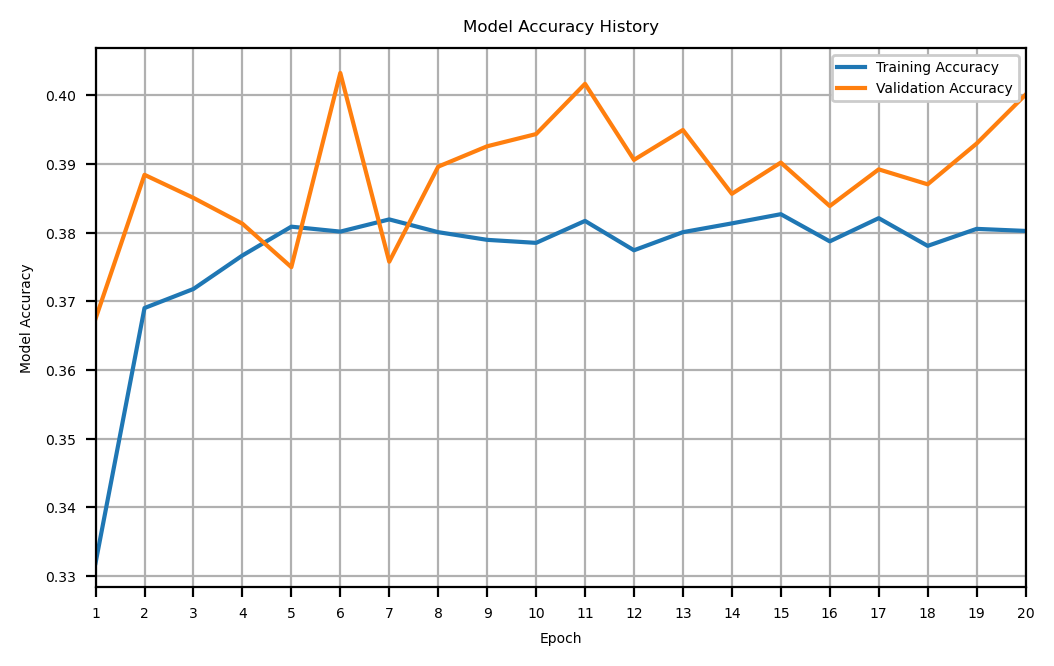

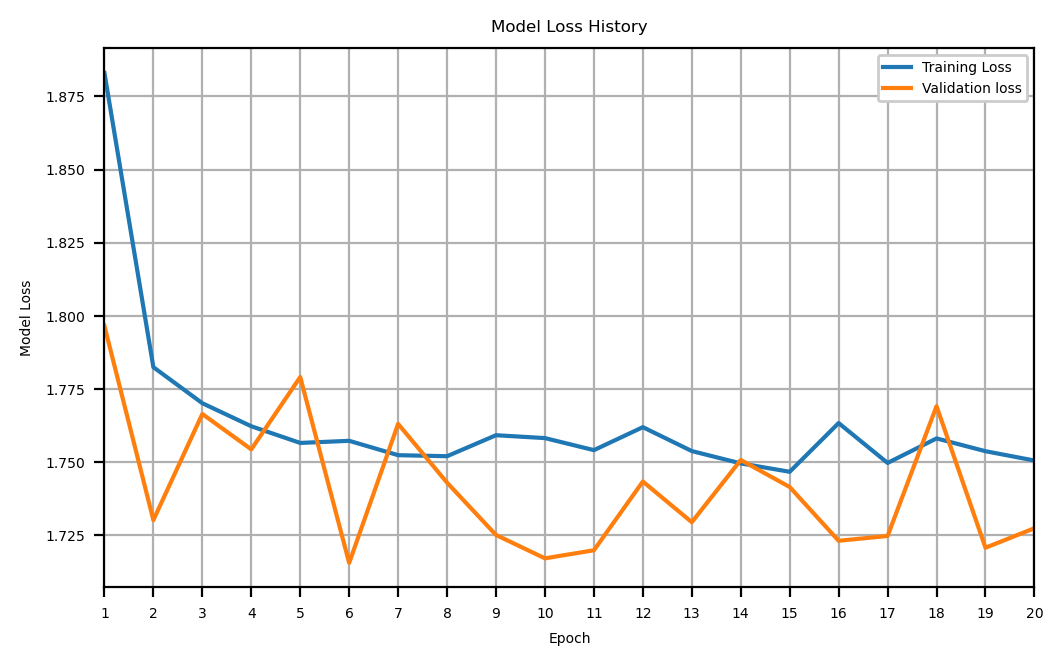

In [8]:
# create function to show model training accuracy and loss history
def model_history(history):
        # plot training history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train accuracy'])+1),
                history['train accuracy'],
                label = r'Training Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation accuracy"])+1),
                history['validation accuracy'],
                label = r'Validation Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Accuracy History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Accuracy')
        ax.set_xlim(1, len(history["train accuracy"]))
        ax.set_xticks(list(range(1,len(history["train accuracy"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

        # plot loss history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train loss'])+1),
                history['train loss'],
                label = r'Training Loss',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation loss"])+1),
                history['validation loss'],
                label = r'Validation loss',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Loss History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Loss')
        ax.set_xlim(1, len(history["train loss"]))
        ax.set_xticks(list(range(1,len(history["train loss"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

# plot training history using the function
model_history(trained_classifier)

We next define the `evaluation` function to evaluate the trained model on the `extracted_test_loader` dataset. Similar to our training loop, this function returns a dictionary of relevant items for analysis and further visual inspection. Namely:
1. Test set accuracy
2. Test set loss
3. Label predictions
4. True labels
5. Softmax probabilities

In [9]:
from sklearn.metrics import accuracy_score

def evaluate(model, test_loader):

    model.to(device)
    model.eval()
    softmax = nn.Softmax(dim=1).to(device)
    
    probs_list = []
    y_true = []
    
    test_loss = 0
    
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.append(labels)

        with torch.no_grad():
            
            # forward pass and loss on model
            linear_outputs = model(inputs)
            loss = criterion(linear_outputs, labels)

        # apply softmax layer
        outputs = softmax(linear_outputs)
        
        # add loss to total
        test_loss += loss.item()
        
        # append softmax probabilities to probs_list
        for prob, label in zip(outputs, labels):
            probs_list.append(prob.cpu().tolist())
            
    
    y_true = torch.cat(y_true, dim=0).cpu()
    
    # compute total loss on test set
    test_loss /= len(test_loader)
    
    # get predicitons
    y_pred = list(np.argmax(np.asarray(probs_list), axis = 1))
    
    # report accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    print("Test Accuracy:", accuracy)
    print("Test Loss: {:.4f}".format(test_loss))
    
    # return dictionary
    evaluation = {
        "accuracy": accuracy,
        "loss": test_loss,
        "y_pred": list(y_pred),
        "y_true": list(y_true),
        "probs": list(probs_list)
    }
    
    return evaluation
        
test_results = evaluate(trained_classifier["model"], test_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.4066
Test Loss: 1.6948


In [10]:
import pandas as pd

def prediction_results(test_results: dict = test_results, test_set = test_set):
    
    # create dataframe from test results for data manipulation
    df = pd.DataFrame(test_results, columns = test_results.keys()).drop(["accuracy", "loss"], axis=1).reset_index()

    # add predicted and true labels to the dataframe
    df["pred_class"] = df["y_pred"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    df["true_class"] = df["y_true"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    # obtain predicted class probability
    df["pred_prob"] = df["probs"].apply(
        lambda x: np.max(x)
    )
    
    # create list of dataframes of top best and worst predictions
    best_predictions = []
    worst_predictions = []
    
    for label in list(CIFAR10_labels.keys()):
        
        # create dataframes of top 5 best and worst predictions
        best_prediction = df.query(str(label)+" == y_true == y_pred").sort_values(by="pred_prob", ascending=False).head(5)
        worst_prediction = df.query(str(label)+" == y_pred != y_true").sort_values(by="pred_prob", ascending=False).head(5)
        
        # append to list of predictions
        best_predictions.append(best_prediction)
        worst_predictions.append(worst_prediction)
    
    # define functino for plotting
    def plotter(df):
        fig = plt.figure(figsize=(10,2), dpi = 200)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.4)

        for i, (idx, row) in enumerate(df.iterrows()):

            ax = fig.add_subplot(1, 5, i+1)
            ax.set_title(
                f"Predicted Class: {row[4]}\n"+
                f"True Class: {row[5]}\n"+
                f"Predicted Class Probability: {row[6]: .4f}"
            )
            
            ## print(CIFAR10_labels[test_set[idx][1]])
            
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            plt.imshow(img)
            
    for best_pred, worst_pred in zip(best_predictions, worst_predictions):
        plotter(best_pred)
        plotter(worst_pred)


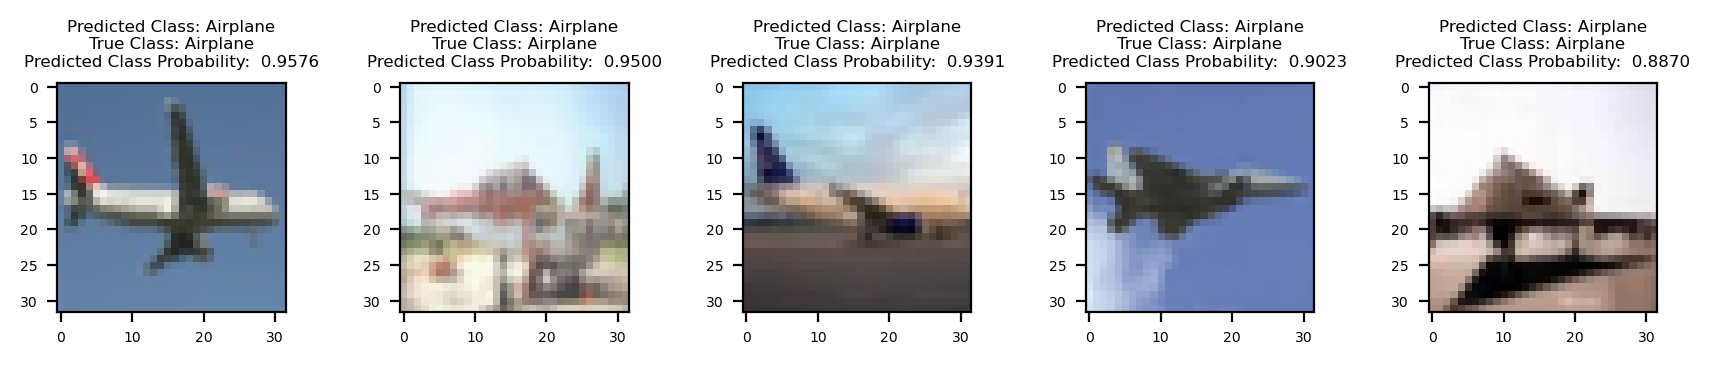

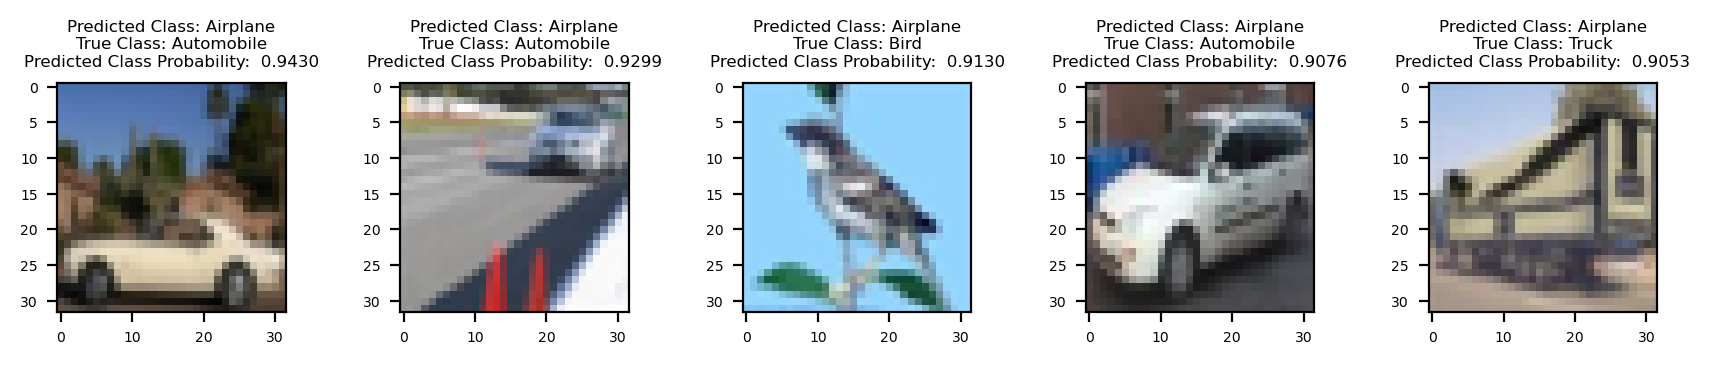

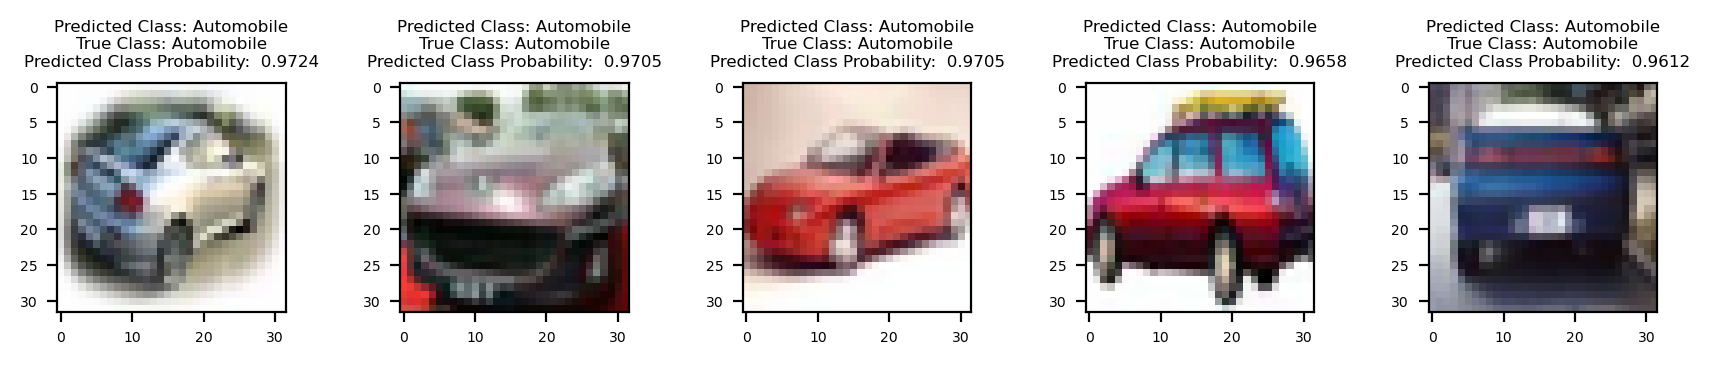

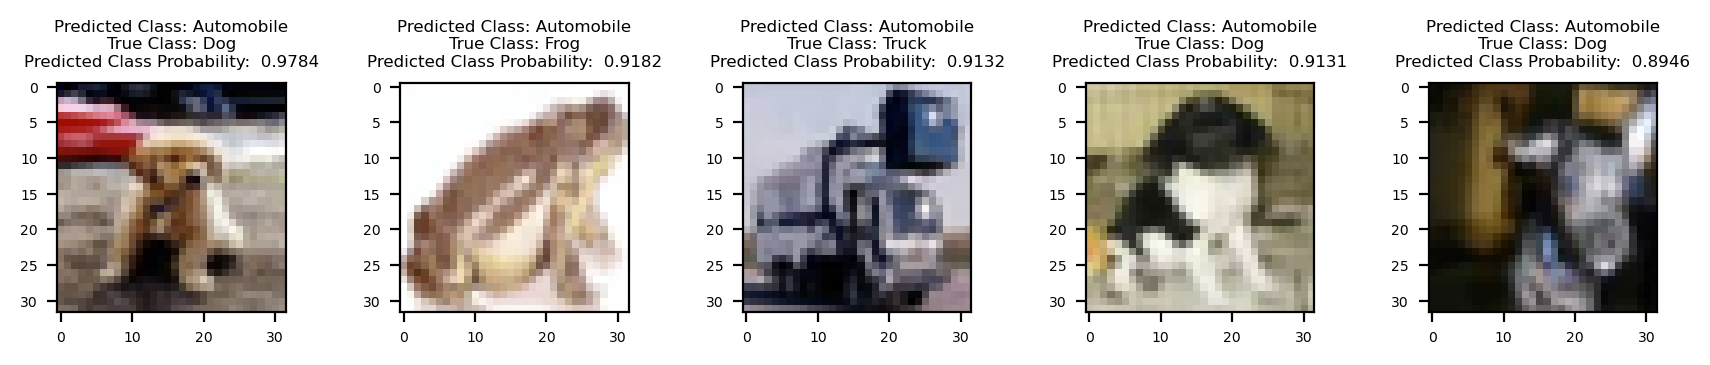

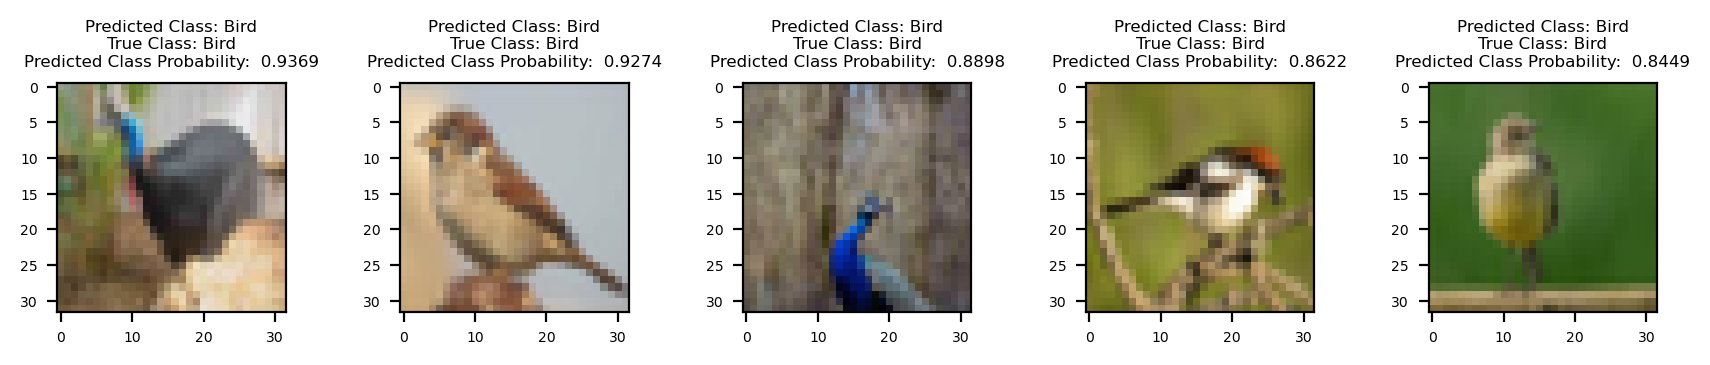

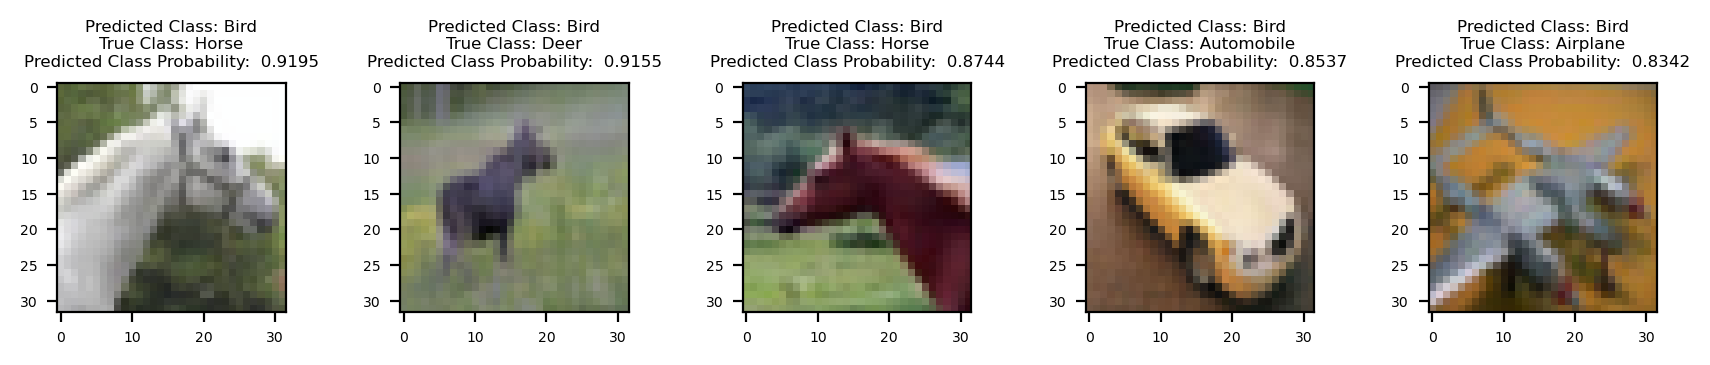

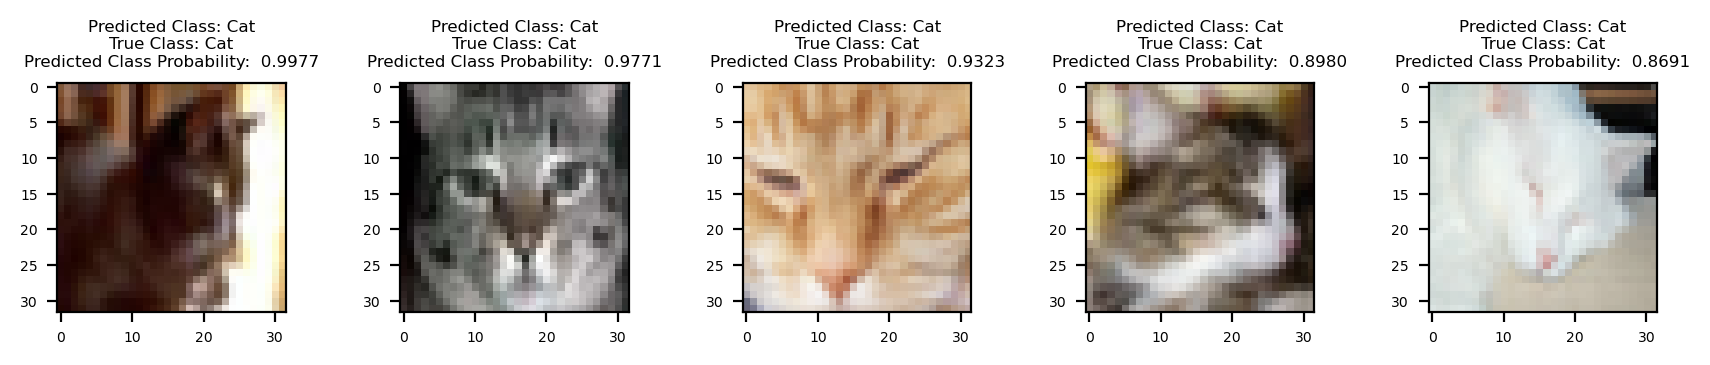

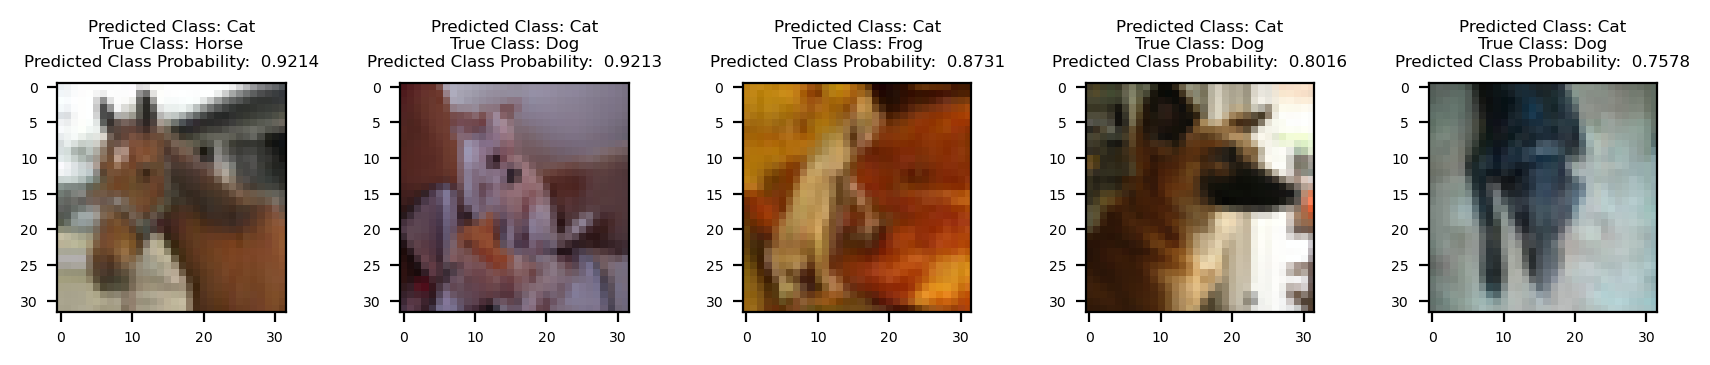

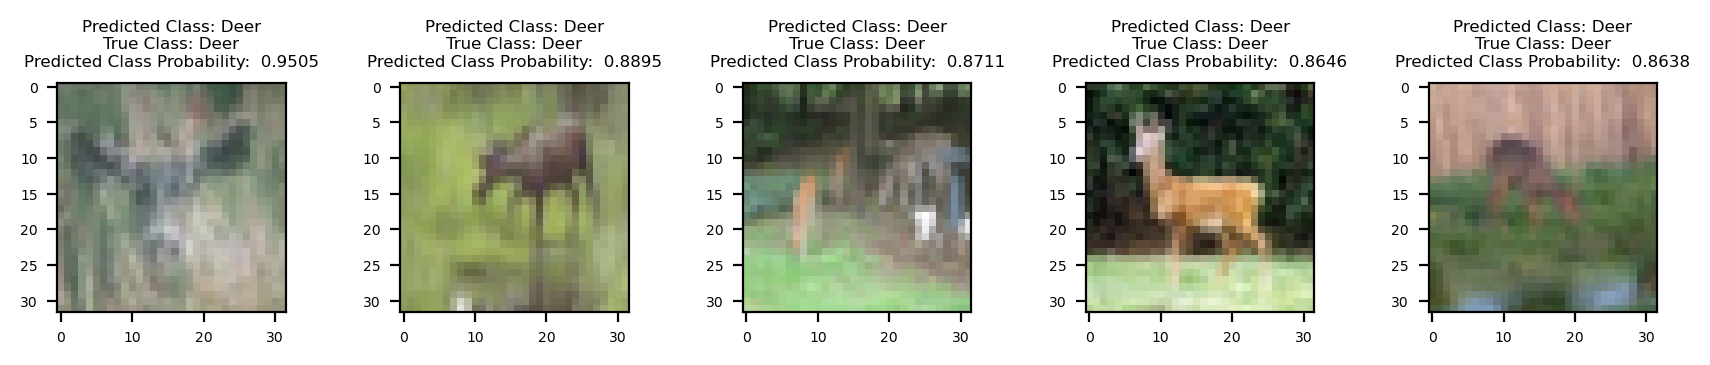

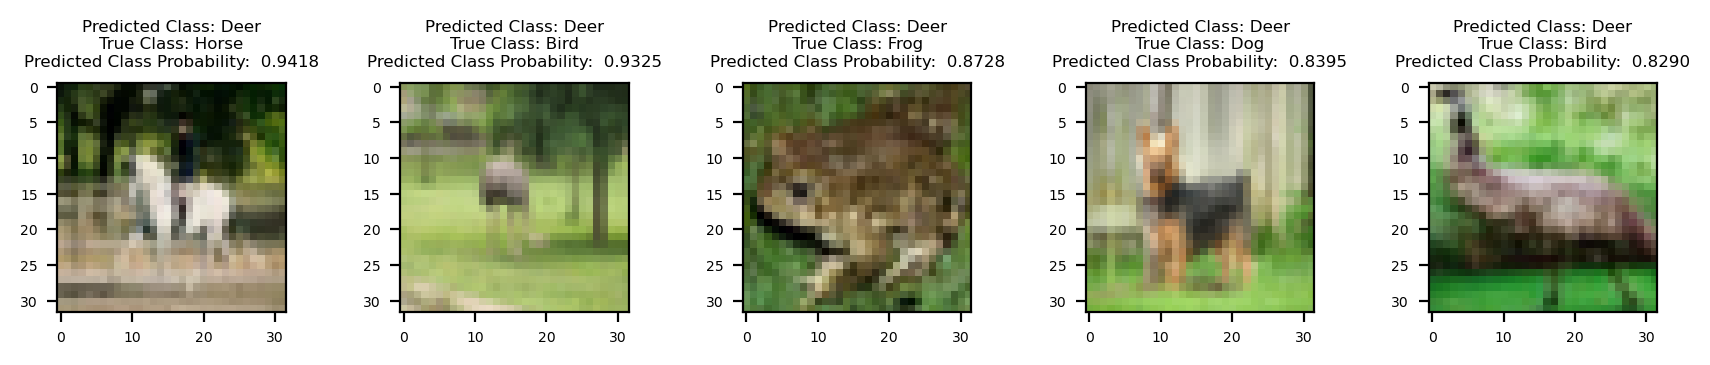

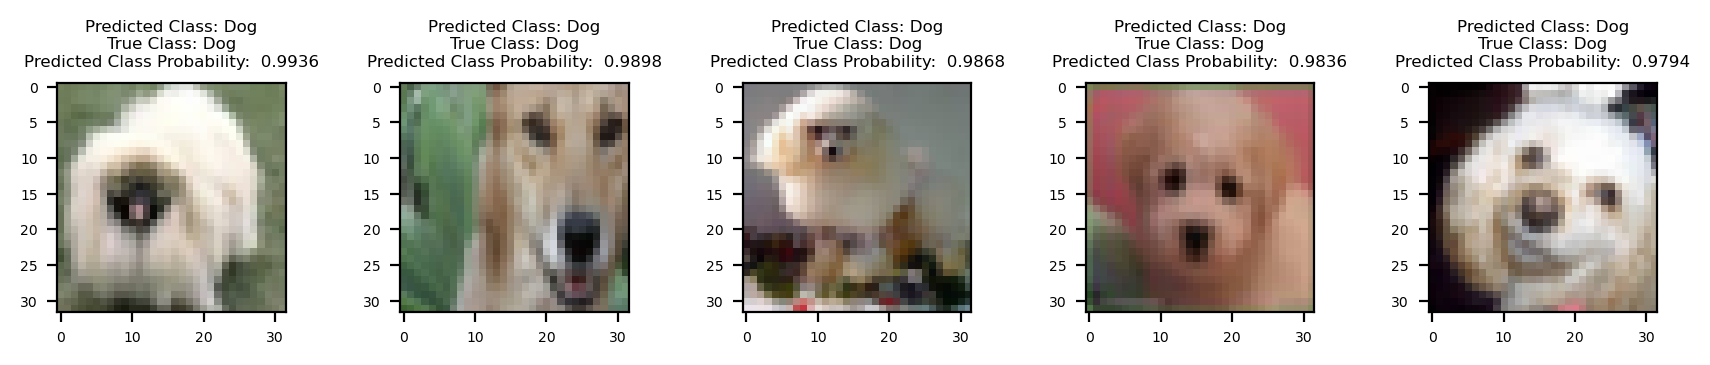

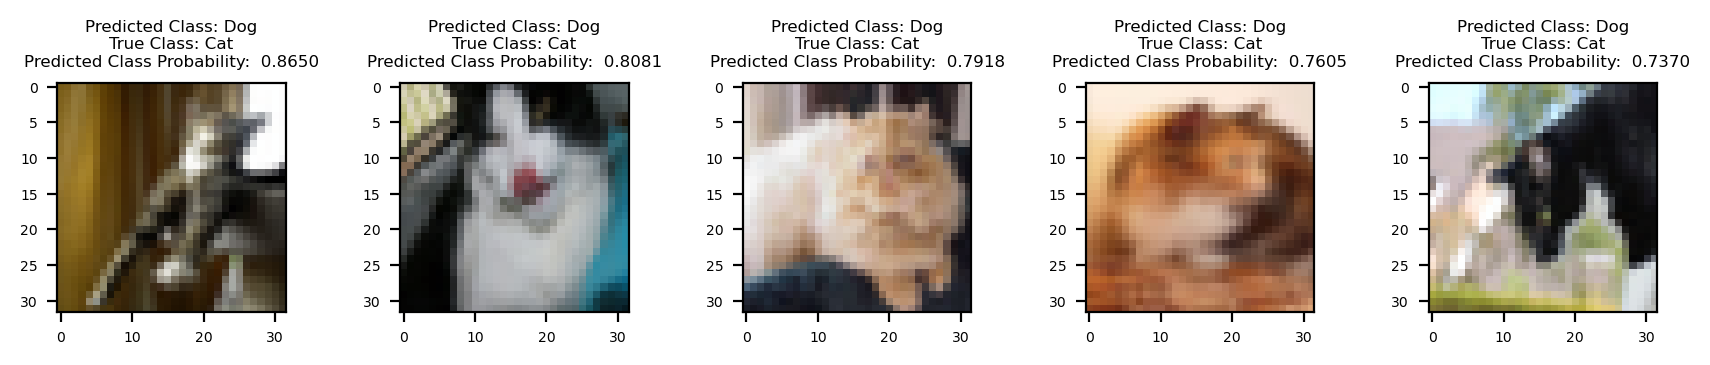

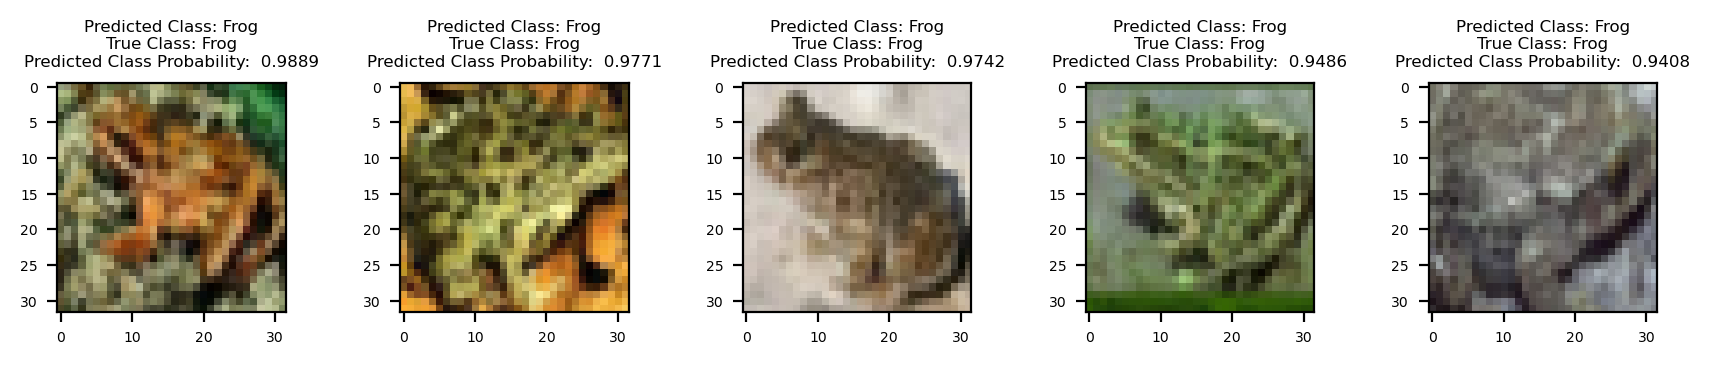

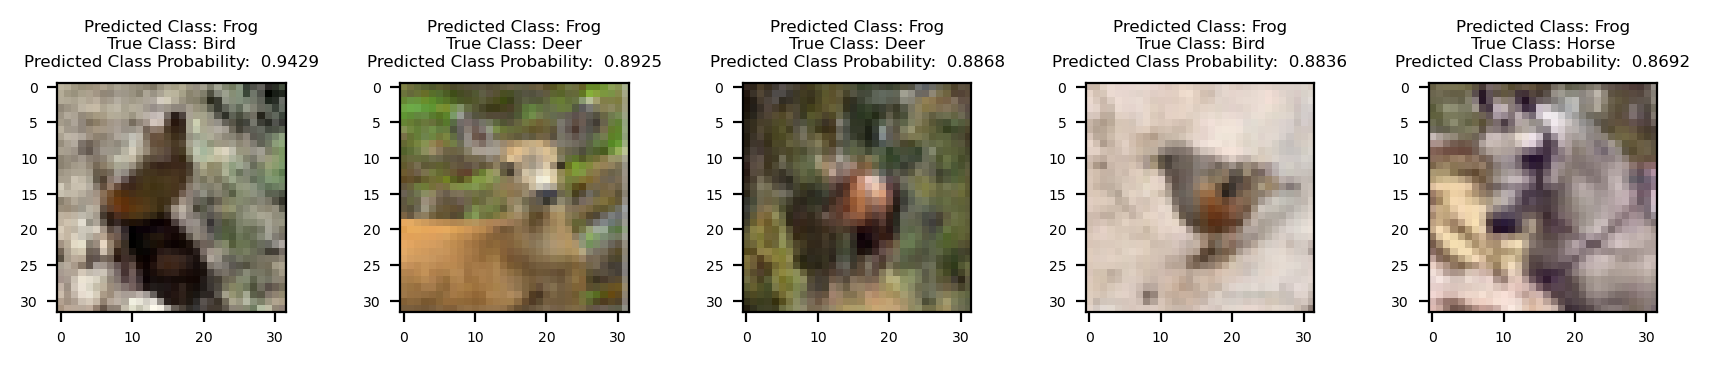

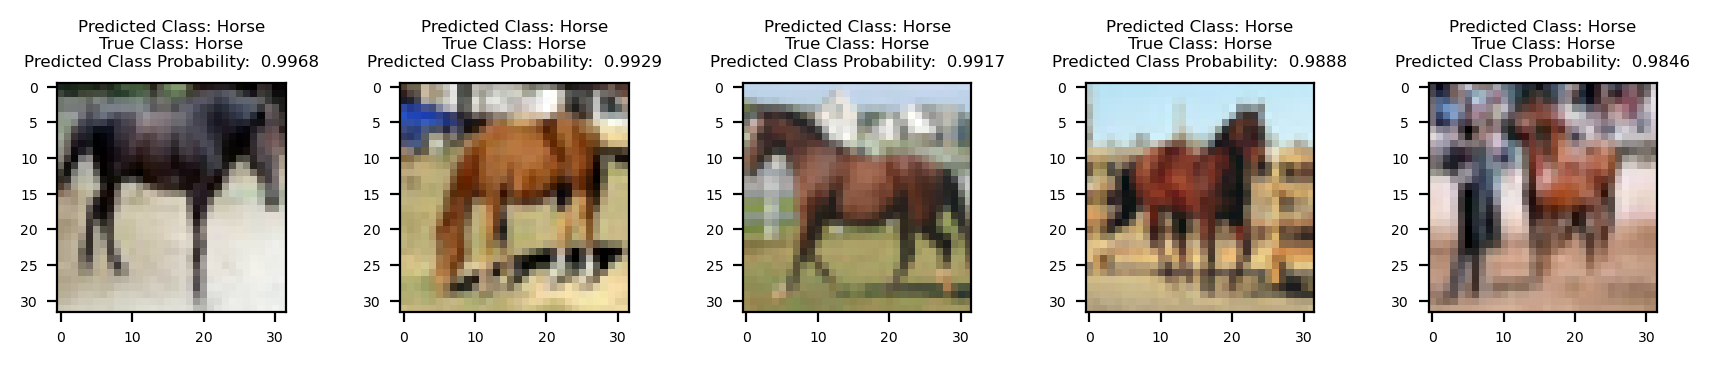

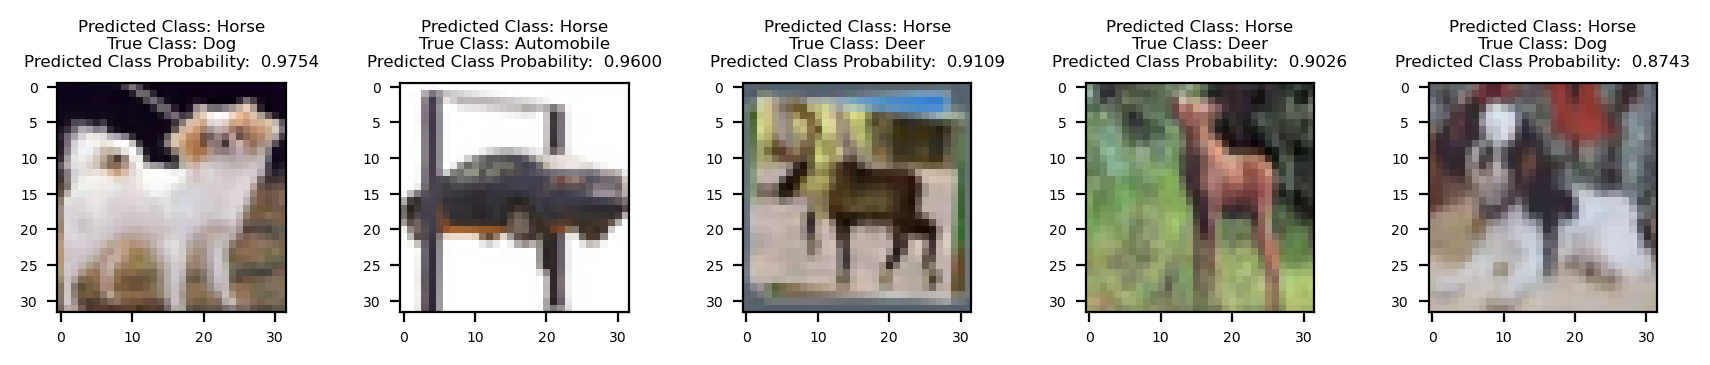

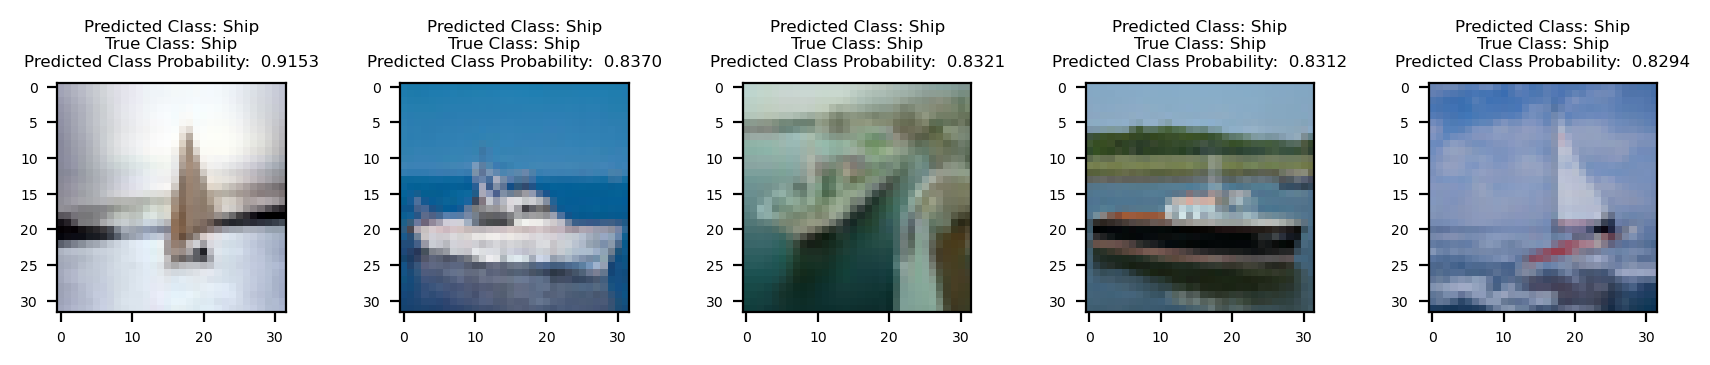

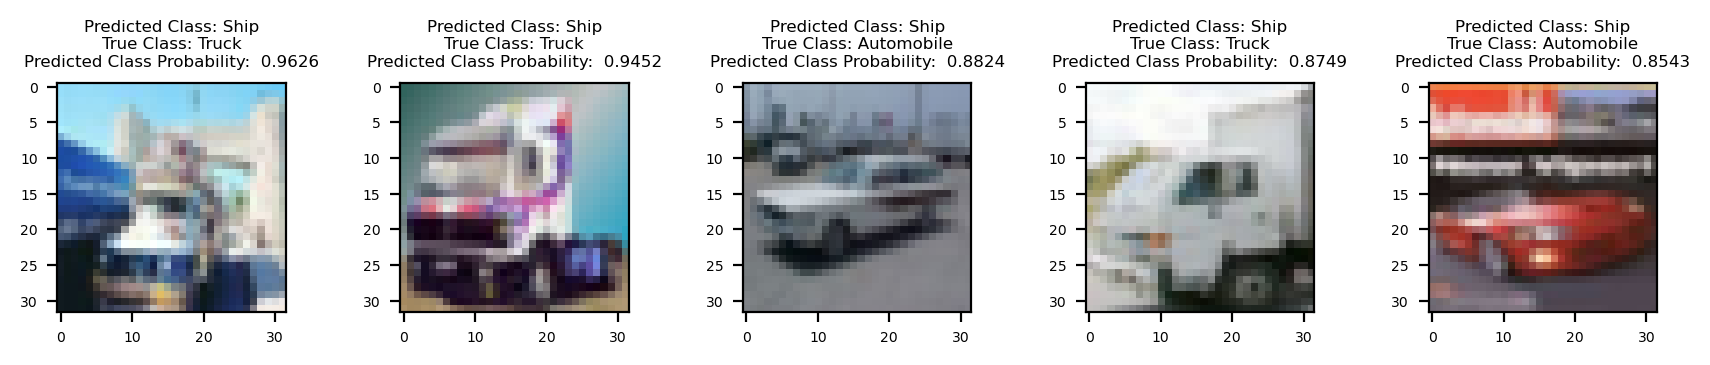

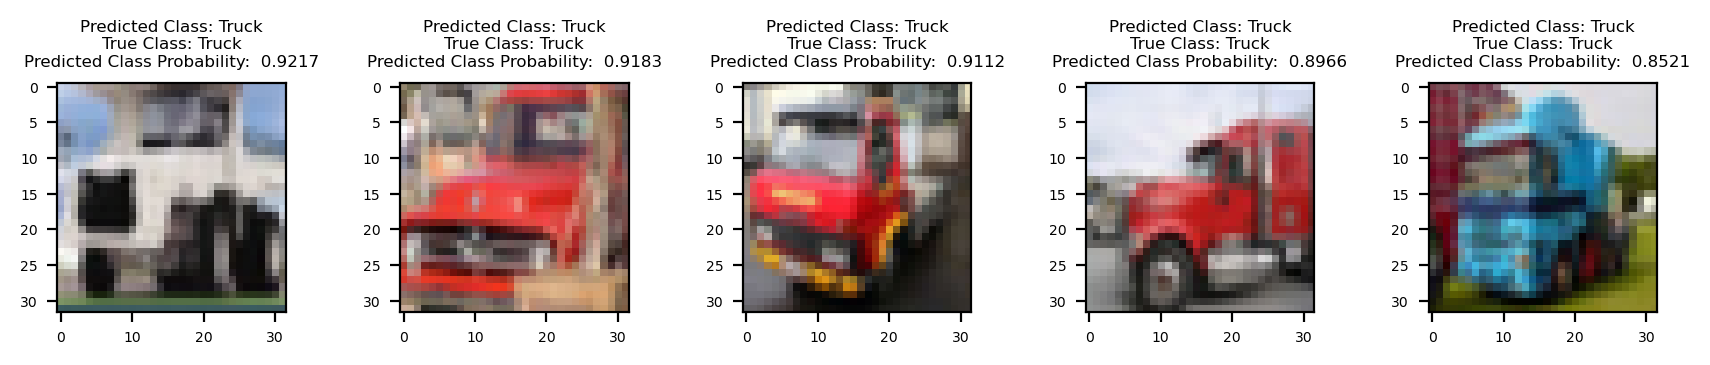

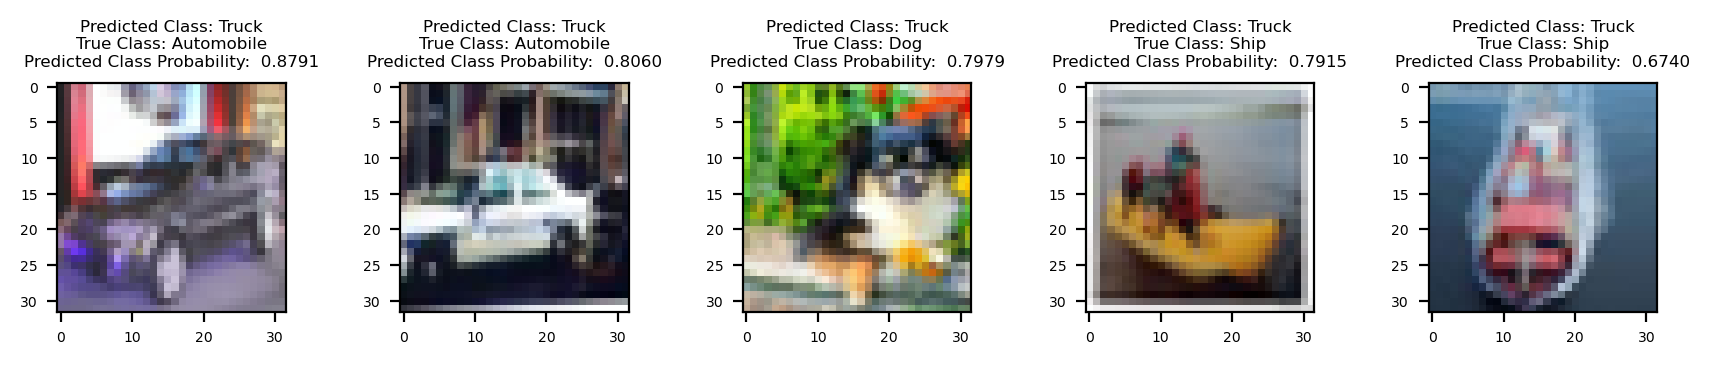

In [11]:
prediction_results(test_results, test_set)

# Fine-Tuning



## Fine-Tuning Preparation:
Make a copy of the pre-trained ResNet-18 model.
Modify the classifier (e.g., replace the final fully connected layer) for the new task (CIFAR-10).

In [12]:
# create transfer learning model
resnet18_tuned = resnet18(weights=ResNet18_Weights.DEFAULT)

# freeze all the layers except for "layer4" and "fc" 
# which are final conv. layers and the fully connected layer
for name, param in resnet18_tuned.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# num_ftrs = resnet18_tuned.fc.in_features # this variable is defined once and we don't change it here
resnet18_tuned.fc = nn.Linear(num_ftrs, 10)

resnet18_tuned.to(device)

# criterion = nn.CrossEntropyLoss() # this variable is defined once and we don't change it here

optimizer_tuned = optim.Adam(filter(lambda p: p.requires_grad, 
                                    resnet18_tuned.parameters()), 
                                    lr=1e-4) # We defined a lower learning rate for fine-tuning

## Fine-Tuning:
Fine-tune the ResNet-18 model on the CIFAR-10 dataset.
Specify the appropriate hyperparameters (e.g., learning rate, number of epochs).

In [13]:
# Train the model for a few more epochs
trained_classifier_fine_tuned = train_model(resnet18_tuned, criterion, optimizer_tuned, 
                                            train_loader, val_loader, num_epochs=10)

Epoch 1/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5314	Train Accuracy: 0.4543
Validation Loss: 1.2861	Validation Accuracy: 0.5437

Epoch 2/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.2578	Train Accuracy: 0.5537
Validation Loss: 1.2226	Validation Accuracy: 0.5997

Epoch 3/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1660	Train Accuracy: 0.5863
Validation Loss: 1.1260	Validation Accuracy: 0.6121

Epoch 4/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.1093	Train Accuracy: 0.6082
Validation Loss: 1.0678	Validation Accuracy: 0.6234

Epoch 5/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0710	Train Accuracy: 0.6209
Validation Loss: 1.0721	Validation Accuracy: 0.6242

Epoch 6/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0293	Train Accuracy: 0.6365
Validation Loss: 1.0639	Validation Accuracy: 0.6371

Epoch 7/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0085	Train Accuracy: 0.6431
Validation Loss: 0.9750	Validation Accuracy: 0.6616

Epoch 8/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9783	Train Accuracy: 0.6547
Validation Loss: 1.0054	Validation Accuracy: 0.6503

Epoch 9/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9591	Train Accuracy: 0.6614
Validation Loss: 1.0474	Validation Accuracy: 0.6487

Epoch 10/10


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.9324	Train Accuracy: 0.6689
Validation Loss: 1.0476	Validation Accuracy: 0.6523



# Model Evaluation:
Evaluate the feature extraction model and fine-tuned model on the test dataset.

In [21]:
print("Results of the tuned model")
test_results_tuned = evaluate(trained_classifier_fine_tuned["model"], test_loader) # results of the tuned model
print("\nResults of the base model")
test_results = evaluate(trained_classifier["model"], test_loader) # results of the tuned model

Results of the tuned model


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.6432
Test Loss: 1.0442

Results of the base model


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.4066
Test Loss: 1.6948


## Confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, class_labels, model_type = None):
    """
    Plot the confusion matrix for a model's predictions on a test dataset.
    Args:
        model: The trained model for which you want to create a confusion matrix.
        test_loader: DataLoader for the test dataset.
        class_labels: List of class labels for mapping the confusion matrix.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix" + " " + model_type)
    plt.show()
    


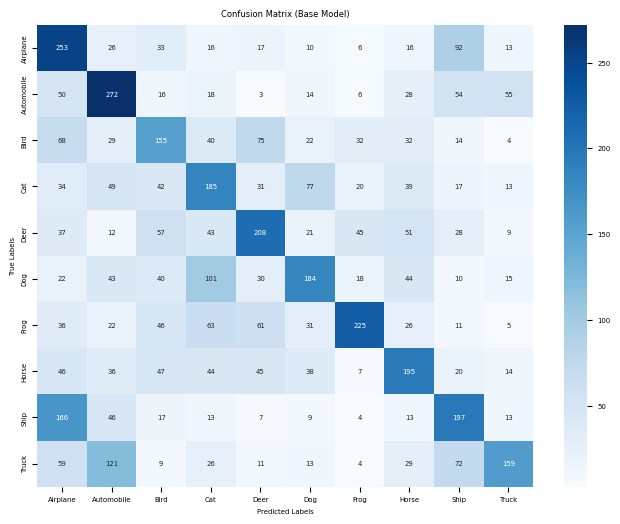

In [16]:
# Define class labels for CIFAR-10
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 
                'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Generate confusion matrix for logistic regression model
plot_confusion_matrix(trained_classifier["model"], 
                      test_loader, class_labels, "(Base Model)")


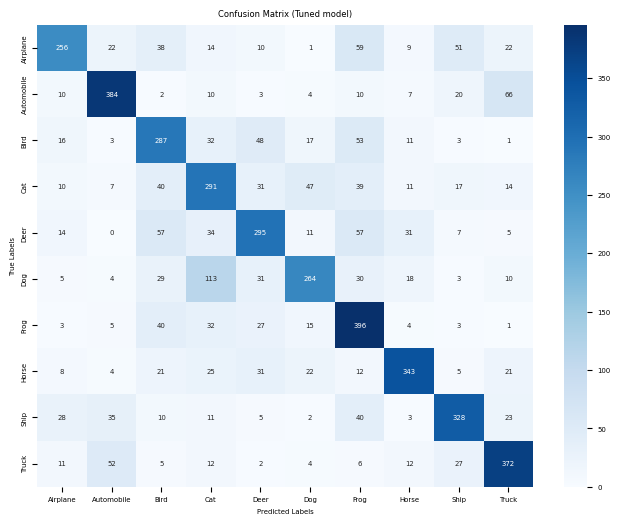

In [17]:
# Generate confusion matrix for fine-tuned ResNet-18 model
plot_confusion_matrix(trained_classifier_fine_tuned["model"], 
                      test_loader, class_labels, "(Tuned model)")

## 2. Movie embeddings


Instead of embedding words, we will embed movies.  In particular, if we can embed movies, then similar movies will be close to each other and can be recommended.  This line of reasoning  is analogous to the [distributional hypothesis of word meanings](https://en.wikipedia.org/wiki/Distributional_semantics). For words, this roughly translates to words that appear in similar sentences should have similar vector representations. For movies, vectors for two movies should be similar if they are watched by similar people.

Let the total number of movies be $M$. Let $X_{i,j}$ be the number of users that liked both movies $i$ and $j$. We want to obtain vectors $v_1,...,v_i,...,v_j,...,v_M$ for all movies such that we minimize the cost $c(v_1,...,v_M) = \sum_{i=1}^{M}\sum_{j=1}^{M}\mathbf{1}_{[i\neq j]}(v_i^Tv_j - X_{i,j})^2$. Here $\mathbf{1}_{[i\neq j]}$ is a function that is $0$ when $i=j$ and $1$ otherwise.

Compute data $X_{i,j}$ from the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip). You can also download using the link to `ml-latest-small.zip` from this [page](https://grouplens.org/datasets/movielens/) (be sure to read the corresponding [description](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)). Briefly describe your data prep workflow (you can use `pandas` if needed).

Optimize function $c(v_1,...,v_M)$ over $v_1,...,v_M$ using gradient descent (using `pytorch` or `tensorflow`). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).

Recommend top 10 movies (not vectors or indices but movie names) given movies (a) _Apollo 13_, (b) _Toy Story_, and (c) _Home Alone_ . Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?

# Please move work from Homework_2_Problem_2.ipynb to here.